In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc
from scipy.stats import norm

## Low Discrepancy sequences

Sobol sequence

In [2]:
def Sobol_seq_normal_transformed(d,m, scramble_func):
    Sobol_seq = qmc.Sobol(d, scramble = scramble_func) # weil scramble ist noch irgendein Extraschritt und default ist True

    sample =  Sobol_seq.random_base2(m)
    #hier nachher wieder ändern
    #sample[0,:] = np.zeros(d)
    #print(sample)

    #uniform random variable to normal distributed random varianle
    return norm.ppf(sample,loc = 0, scale = 1) #scale is standard deviation not variance!!!

Halton Sequence

In [15]:
def Halton_seq_normal_transformed(d, mc_runs, scramble_func):
    Halton_seq = qmc.Halton(d, scramble=scramble_func)
    sample = Halton_seq.random(n=mc_runs)

    return norm.ppf(sample, loc = 0, scale = 1)

Create Brownian Bridges

In [14]:
def create_BB(k, m, QMC, Sobol_not_Halton, scramble_func, mc_runs, d, delta_t):
    h = d                       #h : Differenz der Punkte in Indexpunkten
    X = np.empty((mc_runs,d+1))       #+1 damit die 0 am Anfang mit dabei ist
    X[:,0] = 0

    if QMC == False:
        X[:,d] = np.sqrt(d * delta_t) * np.random.randn(mc_runs)
        for i in range(k):
            h = int(h/2)
            pos = h
            for j in range(2**i):
                X[:,pos] = (1/2) * X[:,pos - h] + (1/2) * X[:,pos + h] + np.sqrt((1/2) * h * delta_t) * np.random.randn(mc_runs)
                #print(pos)
                pos = pos + 2*h
    elif QMC == True:
        if Sobol_not_Halton == True:
            norm_rv = Sobol_seq_normal_transformed(d, m, scramble_func)
            X[:,d] = np.sqrt(d * delta_t) * norm_rv[:, d-1]
            for i in range(k):
                h = int(h/2)
                pos = h
                for j in range(2**i):
                    X[:,pos] = (1/2) * X[:,pos - h] + (1/2) * X[:,pos + h] + np.sqrt((1/2) * h * delta_t) * norm_rv[:,pos-1]
                    #print(pos)
                    pos = pos + 2*h
        elif Sobol_not_Halton == False:
            norm_rv = Halton_seq_normal_transformed(d, mc_runs, scramble_func)
            X[:,d] = np.sqrt(d * delta_t) * norm_rv[:, d-1]
            for i in range(k):
                h = int(h/2)
                pos = h
                for j in range(2**i):
                    X[:,pos] = (1/2) * X[:,pos - h] + (1/2) * X[:,pos + h] + np.sqrt((1/2) * h * delta_t) * norm_rv[:,pos-1]
                    #print(pos)
                    pos = pos + 2*h

    return X

Create Standard Brownian Motion

In [13]:
def create_standard_bm(k, m, QMC, Sobol_not_Halton, scramble_func, mc_runs, d, delta_t):
    if QMC == False:
        #create lower trinangular matrix with ones
        BM = np.empty([mc_runs,d])
        for i in range(mc_runs):
            lower_tri_matr = np.tril(np.ones([d,d]))
            A = math.sqrt(delta_t)*lower_tri_matr
            #create Brownian motion
            BM[i,:] = A.dot(np.random.normal(0,1,d))
    elif QMC == True:
        if Sobol_not_Halton == True:
            BM = np.empty([mc_runs,d])
            norm_rv = Sobol_seq_normal_transformed(d, m, scramble_func)
            for i in range(mc_runs):
                lower_tri_matr = np.tril(np.ones([d,d]))
                A = math.sqrt(delta_t)*lower_tri_matr
                #create Brownian motion
                BM[i,:] = A.dot(norm_rv[i,:])
        elif Sobol_not_Halton == False:
            BM = np.empty([mc_runs,d])
            norm_rv = Halton_seq_normal_transformed(d, mc_runs, scramble_func)
            for i in range(mc_runs):
                lower_tri_matr = np.tril(np.ones([d,d]))
                A = math.sqrt(delta_t)*lower_tri_matr
                #create Brownian motion
                BM[i,:] = A.dot(norm_rv[i,:])

    return BM

Create Asset prices

In [5]:
def create_asset_prices(k, m, QMC, Sobol_not_Halton, scramble_func, BB, mc_runs, d, delta_t, S_0, mu, sigma):
    S = np.empty([mc_runs, d+1]) #+1 weil d mal simuliert wird und aber der Startpreis des Assets auch in dem Vektor steht
    
    S[:,0] = S_0

    if BB == True:
        BM = create_BB(k, m, QMC, Sobol_not_Halton, scramble_func, mc_runs, d, delta_t)
        BM = BM[:,1:len(BM)] #um B_0 abzuschneiden
    else:
        BM = create_standard_bm(k, m, QMC, Sobol_not_Halton, scramble_func, mc_runs, d, delta_t)  #w_0 ist nciht dabei aber interessiert mich auch nicht

    for k in range(mc_runs):
        for i in range(d):
            S[k, i+1] = S[k, 0]*np.exp(sigma*BM[k, i] + (mu-(sigma**2)/2)*(i+1)*delta_t)
    return S
    

Calculate Payoff

In [6]:
def ratched_option(k, m, QMC, Sobol_not_Halton, scramble_func, BB, mc_runs, d, delta_t, S_0, mu, sigma): 
    S = create_asset_prices(k, m, QMC, Sobol_not_Halton, scramble_func, BB, mc_runs, d, delta_t, S_0, mu, sigma)

    indic = np.diff(S)>0

    payoff = (indic*S[:,1:S.size]).mean(axis=1)  #python spezifisch fehlt dann das erste Element

    plt.plot(S.T)
    plt.title("Simulation of "+str(mc_runs)+" sample paths of Asset Prices ")
    plt.show()
    return payoff

# Monte Carlo Simulation

set parameters

In [16]:
T = 1
k = 3
d = 2**k     #2er-Potenz für Brownian Bridge
delta_t = T/d

S_0 = 100
mu = 0.045
sigma = 0.3

m = 7
mc_runs = 2**m    #Für Sobol sequence


Exaktes Ergebnis

In [17]:
Exp = (S_0/d)*norm.cdf((mu-((sigma**2)/2))*math.sqrt(delta_t)/sigma+sigma*math.sqrt(delta_t))*np.sum(np.exp(mu*delta_t*(np.array(range(d))+1)))
display(Exp)

55.618171509982446

Monte Carlo Simulation mit Standard BM und Brownian Bridges

Fehlerberechnung RMSE in Option paper ist es aber irgendwie relativ (weil so nicht wirklich vergleichbar mit verschiedenen Längen der Option)

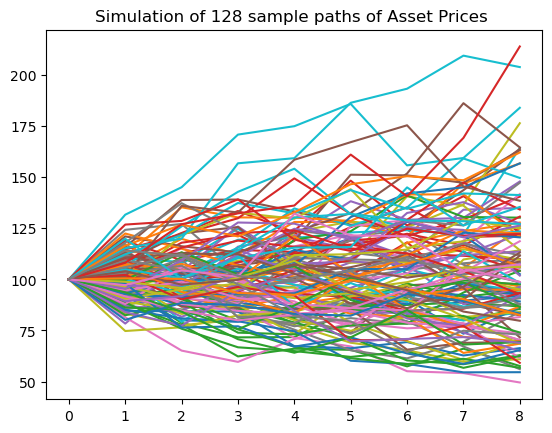

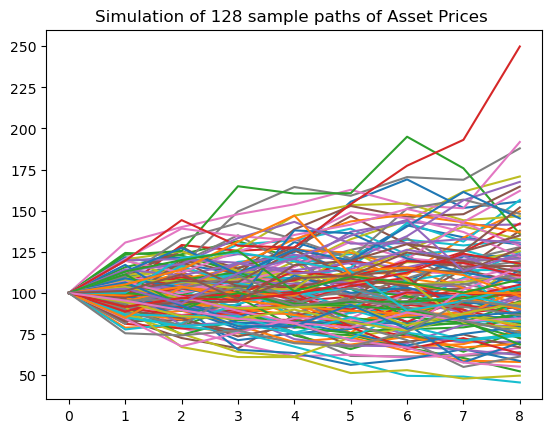

Best MC Expectation with Standard calculation is: 55.81243967600404
Best MC Expectation with Brownian Bridge calculation is: 54.874195762351555


In [20]:
n = np.linspace(10,mc_runs, 1000, dtype = int)
mc_sim_SBM = np.empty(len(n))
mc_sim_BB = np.empty(len(n))

mc_runs = int(n[len(n)-1])

QMC = True
Sobol_not_Halton = False
scramble_func = True


BB = False
payoff_SBM = ratched_option(k, m, QMC, Sobol_not_Halton, scramble_func, BB, mc_runs, d, delta_t, S_0, mu, sigma)

BB = True
payoff_BB = ratched_option(k, m, QMC, Sobol_not_Halton, scramble_func, BB, mc_runs, d, delta_t, S_0, mu, sigma)

#Darf ich die Simulation so machen, in dem ich ich immer ein Teilintervall nehme?
for i in range(len(n)):
    mc_sim_SBM[i] = payoff_SBM[:n[i]].mean() #Hier werden aus Payoff MC Wert berechnet
    mc_sim_BB[i] = payoff_BB[:n[i]].mean()
print("Best MC Expectation with Standard calculation is: " + str(mc_sim_SBM.mean()))
print("Best MC Expectation with Brownian Bridge calculation is: " + str(mc_sim_BB.mean()))


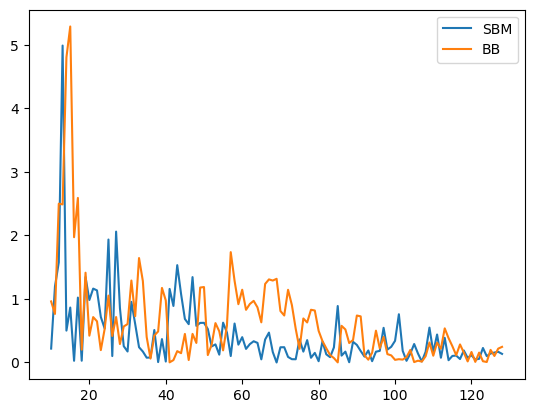

In [19]:
plt.plot(n, np.sqrt((mc_sim_SBM - Exp)**2), label = 'SBM')
plt.plot(n, np.sqrt((mc_sim_BB - Exp)**2), label = 'BB')
plt.legend()
plt.show()